## Coupling ODE and FBA model

Based on recent discussions, (image may be missing)

<img src="IMG_2118.JPG" width="400">

Results from ODE model :

In [1]:
import pandas as pd

#Dataframe containing [CO2] = 270
df270 = pd.read_csv("CO2_270.csv")

#Dataframe containing [CO2] = 400
df400 = pd.read_csv("CO2_400.csv")

#Dataframe containing [CO2] = 700
df700 = pd.read_csv("CO2_700.csv")

Model non-chloroplastic fluxes using FBA

In [2]:
def remove_metabolite_from_reaction(rxn,mets):
    '''
    This functions removes a list of metabolites from a reaction
    '''
    for met in mets:
        if met in rxn.metabolites.keys():
            coeff = rxn.metabolites.get(met)
            rxn.add_metabolites({met:-1*coeff})
        else:
            print("Metabolite "+met.id+" not present in reaction "+rxn.id)
    return rxn

In [3]:
from libsbml import readSBML
from cobra import io,flux_analysis
from cobra.core import Reaction, Metabolite

#import model. Update file name and location in the next line
cobra_model = io.sbml.create_cobra_model_from_sbml_file("PlantCoreMetabolism_v1_2_1.xml")

#Remove all metabolites except sucrose from Phloem
rxn = cobra_model.reactions.get_by_id("Phloem_output_tx")
mets2remove = list()

for met in rxn.metabolites.keys():
    #if "SUCROSE" in met.id:# or "GLC" in met.id or "FRU" in met.id:
    #    continue
    #else:
    #    mets2remove.append(met)
    mets2remove.append(met)

remove_metabolite_from_reaction(rxn,mets2remove)
rxn.add_metabolites({cobra_model.metabolites.get_by_id("sSUCROSE_b"):-1})
#rxn.add_metabolites({cobra_model.metabolites.get_by_id("GAP_c"):-1})
coeff = sum(rxn.metabolites.values())
#rxn.add_metabolites({cobra_model.metabolites.get_by_id("PROTON_c"):-1*coeff,cobra_model.metabolites.get_by_id("PROTON_e"):coeff})

#no external sucrose or glucose
cobra_model.reactions.get_by_id("Sucrose_tx").lower_bound = 0
cobra_model.reactions.get_by_id("Sucrose_tx").upper_bound = 0
cobra_model.reactions.get_by_id("GLC_tx").lower_bound = 0
cobra_model.reactions.get_by_id("GLC_tx").upper_bound = 0

#no external light energy
cobra_model.reactions.get_by_id("Photon_tx").lower_bound = 0
cobra_model.reactions.get_by_id("Photon_tx").upper_bound = 0

#set export of sugars as objective
cobra_model.reactions.get_by_id("Phloem_output_tx").objective_coefficient=1

#add source reaction for TP
rxn = Reaction("GAP_tx",name = "TP source")
rxn.add_metabolites({cobra_model.metabolites.get_by_id("GAP_c"):1})
rxn.upper_bound = 1000
rxn.lower_bound = 0
cobra_model.add_reaction(rxn)

#add source reaction for TP
rxn = Reaction("GLYCOLATE_tx",name = "Glycolate source")
rxn.add_metabolites({cobra_model.metabolites.get_by_id("GLYCOLLATE_c"):1})
rxn.upper_bound = 1000
rxn.lower_bound = 0
cobra_model.add_reaction(rxn)

#add source reaction for TP
rxn = Reaction("GLYCERATE_tx",name = "Glycerate sink")
rxn.add_metabolites({cobra_model.metabolites.get_by_id("GLYCERATE_c"):-1})
rxn.upper_bound = 1000
rxn.lower_bound = 0
cobra_model.add_reaction(rxn)

#remove mGS and cGS
cobra_model.reactions.get_by_id("GLUTAMINESYN_RXN_m").lower_bound = 0
cobra_model.reactions.get_by_id("GLUTAMINESYN_RXN_m").upper_bound = 0
cobra_model.reactions.get_by_id("GLUTAMINESYN_RXN_c").lower_bound = 0
cobra_model.reactions.get_by_id("GLUTAMINESYN_RXN_c").upper_bound = 0

#remove glutamine synthetase and glutamate synthase
#rxn = cobra_model.reactions.get_by_id("GLUTAMATE_SYNTHASE_FERREDOXIN_RXN_p")
#mets2remove=[cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"),cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p")]
#remove_metabolite_from_reaction(rxn,mets2remove)
#rxn = cobra_model.reactions.get_by_id("GLUTAMINESYN_RXN_p")
#mets2remove=[cobra_model.metabolites.get_by_id("ATP_p"),cobra_model.metabolites.get_by_id("aATP_p")]
#remove_metabolite_from_reaction(rxn,mets2remove)

#rxn = Reaction("NrefixationCostbypass")
#rxn.add_metabolites({cobra_model.metabolites.get_by_id("GLT_x"):1,cobra_model.metabolites.get_by_id("2_KETOGLUTARATE_x"):-1,cobra_model.metabolites.get_by_id("AMMONIUM_m"):-1})
#rxn.lower_bound = 0
#rxn.upper_bound = 1000
#cobra_model.add_reaction(rxn)

#provide energy for N fixation 
rxn = Reaction("NrefixationEnergy")
rxn.add_metabolites({cobra_model.metabolites.get_by_id("ATP_p"):0.9,cobra_model.metabolites.get_by_id("aATP_p"):0.1,cobra_model.metabolites.get_by_id("ADP_p"):-0.8,cobra_model.metabolites.get_by_id("aADP_p"):-0.2,cobra_model.metabolites.get_by_id("Pi_p"):-1,cobra_model.metabolites.get_by_id("Reduced_ferredoxins_p"):2,cobra_model.metabolites.get_by_id("Oxidized_ferredoxins_p"):-2})
rxn.lower_bound = 0
rxn.upper_bound = 1000
met = Metabolite("NrefixEnergyConstraint")
rxn.add_metabolites({met:1})
cobra_model.add_reaction(rxn)
cobra_model.reactions.get_by_id("GCVMULTI_RXN_m").add_metabolites({met:-1})

#turn off phosphoserine transaminase
#cobra_model.reactions.get_by_id("PSERTRANSAM_RXN_p").lower_bound = 0
#cobra_model.reactions.get_by_id("PSERTRANSAM_RXN_p").upper_bound = 0


cobra_model.reactions.get_by_id("Pi_ec").lower_bound = -1000
cobra_model.reactions.get_by_id("Pi_ec").upper_bound = 1000

#check if model works
flux_analysis.parsimonious.optimize_minimal_flux(cobra_model)

<Solution 25219.178 at 0x7fd73adf1810>

In [4]:
VSuc_list = list()
for i in range(0,len(df270)):
    temp = cobra_model.copy()
    PPFD = df270["Light intensity"][i]
    #constrain maintenace
    ATPase = (0.0049*PPFD) + 2.7851
    #temp.reactions.get_by_id("ATPase_tx").lower_bound = ATPase
    #temp.reactions.get_by_id("ATPase_tx").upper_bound = ATPase
    
    #constraint TP flux
    temp.reactions.get_by_id("GAP_tx").lower_bound = df270["VT3P"][i]
    temp.reactions.get_by_id("GAP_tx").upper_bound = df270["VT3P"][i]
        
    #constraint glycollate and glycerate fluxes flux
    temp.reactions.get_by_id("GLYCOLATE_tx").lower_bound = df270["Vt_glycolate"][i]
    temp.reactions.get_by_id("GLYCOLATE_tx").upper_bound = df270["Vt_glycolate"][i]
    temp.reactions.get_by_id("GLYCERATE_tx").lower_bound = df270["Vt_glycerate"][i]
    temp.reactions.get_by_id("GLYCERATE_tx").upper_bound = df270["Vt_glycerate"][i]
    
    #temp.reactions.get_by_id("NrefixationCostbypass").lower_bound = df270["Vt_glycolate"][i]
    #temp.reactions.get_by_id("NrefixationCostbypass").upper_bound = df270["Vt_glycolate"][i]
    
    #temp.reactions.get_by_id("NrefixationEnergy").lower_bound = df270["Vt_glycerate"][i]
    #temp.reactions.get_by_id("NrefixationEnergy").upper_bound = df270["Vt_glycerate"][i]
    
    #check if model works
    sol = flux_analysis.parsimonious.optimize_minimal_flux(temp)
    VSuc = temp.reactions.get_by_id("Phloem_output_tx").x
    #print(PPFD)
    #print(temp.reactions.get_by_id("Phloem_output_tx").x)
    #print(temp.reactions.get_by_id("GLYCOLATE_tx").x)
    #print(temp.reactions.get_by_id("GLYCERATE_tx").x)
    #print("------------")
    VSuc_list.append(VSuc)
df270["VSuc"] = VSuc_list
df270

,Hour,Light intensity,Vc,Vo,VPGA,VT3P,Vstarch,Vt_glycerate,Vt_glycolate,VSuc
0,5,107.7,4.664680,2.332340,0.000997,1.125951,0.019612,1.166170,2.332340,0.278325
1,6,463.5,15.865910,7.932957,0.006077,3.314910,0.322746,3.966478,7.932957,0.819416
2,7,851.1,16.513580,8.256788,0.006274,3.389420,0.366350,4.128394,8.256788,0.837834
3,8,1225.5,16.596440,8.298222,0.006334,3.407314,0.367732,4.149111,8.298222,0.842257
4,9,1543.9,16.651880,8.325941,0.006373,3.419290,0.368653,4.162970,8.325941,0.845218
5,10,1792.5,16.689730,8.344865,0.006401,3.427468,0.369282,4.172433,8.344865,0.847239
6,11,1946.0,16.711250,8.355627,0.006416,3.432119,0.369639,4.177813,8.355627,0.848389
7,12,1998.3,16.718300,8.359149,0.006422,3.433641,0.369755,4.179574,8.359149,0.848765
8,13,1944.3,16.710990,8.355493,0.006416,3.432061,0.369635,4.177746,8.355493,0.848375
9,14,1786.0,16.688720,8.344359,0.006400,3.427250,0.369265,4.172180,8.344359,0.847185


In [6]:
#from SweetloveGroup.analysis import generateFluxMap
#generateFluxMap(temp,sol,"test.fluxMap",phases=1)

In [7]:
VSuc_list = list()
for i in range(0,len(df400)):
    temp = cobra_model.copy()
    PPFD = df400["Light intensity"][i]
    #constrain maintenace
    ATPase = (0.0049*PPFD) + 2.7851
    #temp.reactions.get_by_id("ATPase_tx").lower_bound = ATPase
    #temp.reactions.get_by_id("ATPase_tx").upper_bound = ATPase
    
    #constraint TP flux
    temp.reactions.get_by_id("GAP_tx").lower_bound = df400["VT3P"][i]
    temp.reactions.get_by_id("GAP_tx").upper_bound = df400["VT3P"][i]
        
    #constraint glycollate and glycerate fluxes flux
    temp.reactions.get_by_id("GLYCOLATE_tx").lower_bound = df400["Vt_glycolate"][i]
    temp.reactions.get_by_id("GLYCOLATE_tx").upper_bound = df400["Vt_glycolate"][i]
    temp.reactions.get_by_id("GLYCERATE_tx").lower_bound = df400["Vt_glycerate"][i]
    temp.reactions.get_by_id("GLYCERATE_tx").upper_bound = df400["Vt_glycerate"][i]
    
    #check if model works
    sol = flux_analysis.parsimonious.optimize_minimal_flux(temp)
    VSuc = temp.reactions.get_by_id("Phloem_output_tx").x
    #print(PPFD)
    #print(temp.reactions.get_by_id("Phloem_output_tx").x)
    #print(temp.reactions.get_by_id("GLYCOLATE_tx").x)
    #print(temp.reactions.get_by_id("GLYCERATE_tx").x)
    #print("------------")
    VSuc_list.append(VSuc)
df400["VSuc"] = VSuc_list
df400

,Hour,Light intensity,Vc,Vo,VPGA,VT3P,Vstarch,Vt_glycerate,Vt_glycolate,VSuc
0,5,107.7,5.515704,1.861550,0.001732,1.475786,0.025397,0.930775,1.861550,0.364801
1,6,463.5,20.266090,6.839807,0.011410,4.554486,0.524754,3.419904,6.839807,1.125828
2,7,851.1,22.844400,7.709984,0.009772,4.343701,0.988165,3.854992,7.709984,1.073724
3,8,1225.5,22.908740,7.731700,0.009822,4.356110,0.990849,3.865850,7.731700,1.076791
4,9,1543.9,22.949650,7.745507,0.009856,4.364373,0.992368,3.872753,7.745507,1.078834
5,10,1792.5,22.976910,7.754707,0.009878,4.369881,0.993380,3.877354,7.754707,1.080195
6,11,1946.0,22.992300,7.759901,0.009891,4.372991,0.993951,3.879951,7.759901,1.080964
7,12,1998.3,22.997270,7.761578,0.009895,4.373995,0.994135,3.880789,7.761578,1.081212
8,13,1944.3,22.992220,7.759876,0.009891,4.372976,0.993948,3.879938,7.759876,1.080960
9,14,1786.0,22.976240,7.754481,0.009878,4.369745,0.993355,3.877240,7.754481,1.080162


In [8]:
VSuc_list = list()
for i in range(0,len(df700)):
    temp = cobra_model.copy()
    PPFD = df700["Light intensity"][i]
    #constrain maintenace
    ATPase = (0.0049*PPFD) + 2.7851
    #temp.reactions.get_by_id("ATPase_tx").lower_bound = ATPase
    #temp.reactions.get_by_id("ATPase_tx").upper_bound = ATPase
    
    #constraint TP flux
    temp.reactions.get_by_id("GAP_tx").lower_bound = df700["VT3P"][i]
    temp.reactions.get_by_id("GAP_tx").upper_bound = df700["VT3P"][i]
        
    #constraint glycollate and glycerate fluxes flux
    temp.reactions.get_by_id("GLYCOLATE_tx").lower_bound = df700["Vt_glycolate"][i]
    temp.reactions.get_by_id("GLYCOLATE_tx").upper_bound = df700["Vt_glycolate"][i]
    temp.reactions.get_by_id("GLYCERATE_tx").lower_bound = df700["Vt_glycerate"][i]
    temp.reactions.get_by_id("GLYCERATE_tx").upper_bound = df700["Vt_glycerate"][i]
    
    #check if model works
    sol = flux_analysis.parsimonious.optimize_minimal_flux(temp)
    VSuc = temp.reactions.get_by_id("Phloem_output_tx").x
    #print(PPFD)
    #print(temp.reactions.get_by_id("Phloem_output_tx").x)
    #print(temp.reactions.get_by_id("GLYCOLATE_tx").x)
    #print(temp.reactions.get_by_id("GLYCERATE_tx").x)
    #print("------------")
    VSuc_list.append(VSuc)
df700["VSuc"] = VSuc_list
df700

,Hour,Light intensity,Vc,Vo,VPGA,VT3P,Vstarch,Vt_glycerate,Vt_glycolate,VSuc
0,5,107.7,6.431560,1.240372,0.002837,1.875521,0.029383,0.620186,1.240372,0.463612
1,6,463.5,23.992000,4.627029,0.019405,5.878908,0.663921,2.313514,4.627029,1.453213
2,7,851.1,27.515400,5.306542,0.011882,4.845631,1.714932,2.653271,5.306542,1.197796
3,8,1225.5,27.543040,5.311872,0.011881,4.846387,1.718717,2.655936,5.311872,1.197983
4,9,1543.9,27.558590,5.314871,0.011894,4.849346,1.719573,2.657436,5.314871,1.198715
5,10,1792.5,27.568820,5.316844,0.011903,4.851296,1.720134,2.658422,5.316844,1.199197
6,11,1946.0,27.574620,5.317963,0.011908,4.852403,1.720452,2.658982,5.317963,1.199470
7,12,1998.3,27.576510,5.318327,0.011909,4.852762,1.720555,2.659163,5.318327,1.199559
8,13,1944.3,27.574600,5.317959,0.011908,4.852398,1.720450,2.658979,5.317959,1.199469
9,14,1786.0,27.568620,5.316805,0.011903,4.851258,1.720123,2.658403,5.316805,1.199187


<img src="Screenshot_20190515_082817.png">

Flux Map (Image may be missing)
 - complete TCA active  
 - glutamine synthetase (costs ATP) active in mitochondria  
 - glutamate synthetase (costs reducing power) active in chloroplast  
 
Suggestions
 - N refixing has to be assigned to ODE  
 

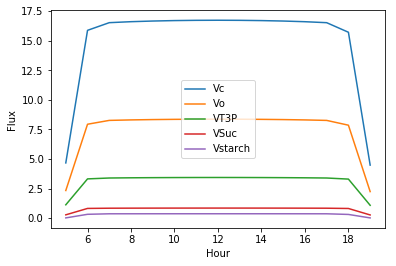

In [12]:
import matplotlib.pyplot as plt
#plt.plot(df270["Light intensity"])
plt.plot(df270["Hour"],df270["Vc"],label="Vc")
plt.plot(df270["Hour"],df270["Vo"],label="Vo")
plt.plot(df270["Hour"],df270["VT3P"],label="VT3P")
plt.plot(df270["Hour"],df270["VSuc"],label="VSuc")
plt.plot(df270["Hour"],df270["Vstarch"],label="Vstarch")
plt.xlabel("Hour")
plt.ylabel("Flux")
plt.legend(loc="center")
plt.show()

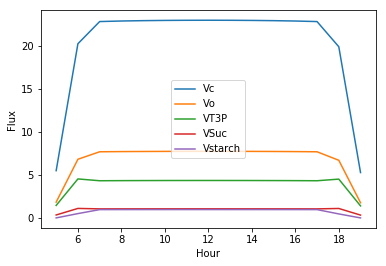

In [10]:
import matplotlib.pyplot as plt
#plt.plot(df400["Light intensity"])
plt.plot(df400["Hour"],df400["Vc"],label="Vc")
plt.plot(df400["Hour"],df400["Vo"],label="Vo")
plt.plot(df400["Hour"],df400["VT3P"],label="VT3P")
plt.plot(df400["Hour"],df400["VSuc"],label="VSuc")
plt.plot(df400["Hour"],df400["Vstarch"],label="Vstarch")
plt.xlabel("Hour")
plt.ylabel("Flux")
plt.legend(loc="center")
plt.show()

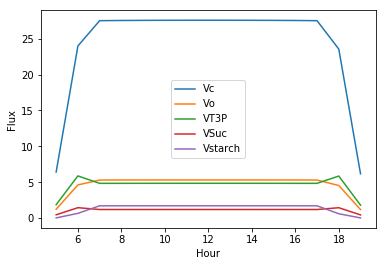

In [11]:
import matplotlib.pyplot as plt
#plt.plot(df700["Light intensity"])
plt.plot(df700["Hour"],df700["Vc"],label="Vc")
plt.plot(df700["Hour"],df700["Vo"],label="Vo")
plt.plot(df700["Hour"],df700["VT3P"],label="VT3P")
plt.plot(df700["Hour"],df700["VSuc"],label="VSuc")
plt.plot(df700["Hour"],df700["Vstarch"],label="Vstarch")
plt.xlabel("Hour")
plt.ylabel("Flux")
plt.legend(loc="center")
plt.show()